In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets,models, transforms
import os
import numpy as np

In [3]:
# Data augmentation and normalization for training
# Just normalize for validation
# class torchvision.transforms.RandomResizedCrop(size, scale = (0.08,1.0), ratio = (0.75,1.333333333333), interpolation = 2)
# transforms.RandomResizedCrop(224) --> A crop of random size (default of 0.08 to 1.0) of the original size and a 
# random aspect ratio (default of 3/4 to 4/3) of the original aspect ratio is made
# This crop is finally resized to given size (224 in this case)
# transforms.CenterCrop(224) --> Crops the image at the center. 224 is the desired output size of the crop

# class torchvision.transforms.Normalize(mean,std)
# Normalize a tensor image with mean and standard deviation. Given mean: (M1,..., Mn) and std: (S1,...,Sn) for n channels
# this transform will normalize each channel of the input torch.Tensor i.e.
# output[channel] = (input[channel] - mean[channel]) / std[channel]

# Parameters mean (sequence) --->  Sequence of means for each channel
#            std (sequence)  --->  Sequence of standard deviations for each channel

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val':  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

Loading the Dataset with labels based on folder names (super important) (also remember to download the dataset from udemy, lesson 150)

In [7]:
data_dir = '..\hymenoptera_data'
# Create a dictionary that contains the information of the images in both the training and validation set
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train','val']}
# Create a dictionary that contains the data loader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True) for x in ['train','val']}

# Create a dictionary that contains the size of each dataset (training and validation)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
# Get the class names
class_names = image_datasets['train'].classes
# Print out the results 
print('Class names {}'.format(class_names))
print('There are {} batches in the training set'.format(len(dataloaders['train'])))
print('There are {} batches in the test set'.format(len(dataloaders['val'])))
print('There are {} training images'.format(dataset_sizes['train']))
print('There are {} testing images'.format(dataset_sizes['val']))


Class names ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 testing images


Loading and Modifying a Pre-Trained Network

In [8]:
# Load the ResNet
model_conv = torchvision.models.resnet18(pretrained = True) # Resnet with 18 layers

C:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\PC/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [9]:
# Freeze all layers in the network
for param in model_conv.parameters():
    param.requires_grad = False # This prevents backpropagation in all layers

In [10]:
# Get the number of inputs of the last layer (or number of neurons in the layer preceding last layer)
num_ftrs = model_conv.fc.in_features # number of inputs features that enter the fully connected part of the resnet
# Reconstruct the last layer (output layer) to have only two classes
model_conv.fc = nn.Linear(num_ftrs, 2)

In [11]:
# Move the network to the GPU if available
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

Understanding what's happening

In [12]:
iteration = 0
correct = 0
for inputs, labels in dataloaders['train']:
    if iteration == 1:
        break
    inputs = Variable(inputs)
    labels = Variable(labels)
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        labels = labels.cuda()
    print('For one iteration this is what happens:')
    print('Input Shape', inputs.shape)
    print('Labels Shape', labels.shape)
    print('Labels are {}'.format(labels))
    output = model_conv(inputs)
    print('Output Tensor:', output)
    print('Outputs Shape', output.shape)
    _, predicted = torch.max(output, 1)
    print('Predicted:', predicted)
    print('Predicted Shape', predicted.shape)
    correct += (predicted == labels).sum()
    print('Correct Predictions:', correct)

    iteration += 1
 

For one iteration this is what happens:
Input Shape torch.Size([4, 3, 224, 224])
Labels Shape torch.Size([4])
Labels are tensor([0, 1, 1, 1], device='cuda:0')
Output Tensor: tensor([[ 0.9907, -0.6174],
        [ 1.0446, -0.7777],
        [ 0.4842, -0.2153],
        [ 1.5191, -0.1002]], device='cuda:0', grad_fn=<AddmmBackward0>)
Outputs Shape torch.Size([4, 2])
Predicted: tensor([0, 0, 0, 0], device='cuda:0')
Predicted Shape torch.Size([4])
Correct Predictions: tensor(1, device='cuda:0')


In [13]:
criterion = nn.CrossEntropyLoss() # can also use the binary cross entropy, just adjust as needed (because we have 2 classes only bees and ants)
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# try experimenting with: optim.Adam(model_conv.fc.parameters(), lr=0.001)
# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7,gamma=0.1)

Training the Network (Fine tuning existing network)

In [14]:
num_epochs = 25
for epoch in range(num_epochs):
    exp_lr_scheduler.step()
    # Reset the correct to 0 after passing through all the dataset
    correct = 0
    for images, labels in dataloaders['train']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad() # Reset the gradient to avoid stacking
        outputs = model_conv(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum()
    train_acc = 100 * correct / dataset_sizes['train']
    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {}%'.format(epoch + 1, num_epochs, loss.item(), train_acc)) 

C:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [1/25], Loss: 0.1853, Train Accuracy: 73.36064910888672%
Epoch [2/25], Loss: 0.1484, Train Accuracy: 80.32786560058594%
Epoch [3/25], Loss: 0.1106, Train Accuracy: 77.04917907714844%
Epoch [4/25], Loss: 0.2830, Train Accuracy: 79.09835815429688%
Epoch [5/25], Loss: 0.1378, Train Accuracy: 79.09835815429688%
Epoch [6/25], Loss: 0.1781, Train Accuracy: 75.81967163085938%
Epoch [7/25], Loss: 0.3643, Train Accuracy: 82.37704467773438%
Epoch [8/25], Loss: 0.1025, Train Accuracy: 84.42622375488281%
Epoch [9/25], Loss: 0.5709, Train Accuracy: 81.96720886230469%
Epoch [10/25], Loss: 0.1414, Train Accuracy: 85.65573120117188%
Epoch [11/25], Loss: 0.0309, Train Accuracy: 85.24589538574219%
Epoch [12/25], Loss: 0.4307, Train Accuracy: 84.42622375488281%
Epoch [13/25], Loss: 0.0796, Train Accuracy: 88.93441772460938%
Epoch [14/25], Loss: 0.6527, Train Accuracy: 78.2786865234375%
Epoch [15/25], Loss: 0.1780, Train Accuracy: 84.8360595703125%
Epoch [16/25], Loss: 0.1479, Train Accuracy: 81.147

Test the Model

In [15]:
model_conv.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for (images,labels) in dataloaders['val']:
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_conv(images)
        _, predicted = torch.max(outputs,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.3f} %'.format(100 * correct/total))
        

Test Accuracy: 94.118 %


Visualize some predictions

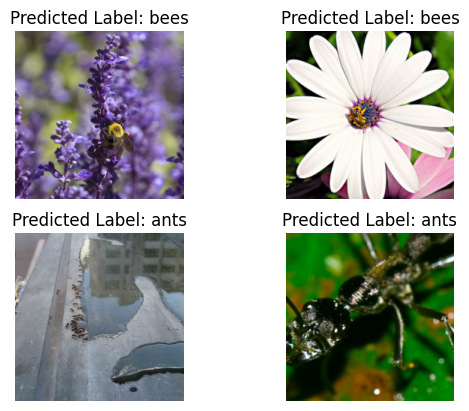

In [29]:
import matplotlib.pyplot as plt
fig = plt.figure()
shown_batch = 0
index = 0
with torch.no_grad():
    for (images, labels) in dataloaders['val']:
        if shown_batch == 1: # show 1 batch only
            break
        shown_batch += 1
        images = Variable(images)
        labels = Variable(labels)
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        outputs = model_conv(images) # Output is of shape (4,2) 4 images and 2 labels, remember batch size is 4
        _, predicted = torch.max(outputs,1) # predicted is of shape (4) --> [0,0,0,1]

        for i in range(4):
            index += 1
            ax = plt.subplot(2,2,index)
            ax.axis('off')
            ax.set_title('Predicted Label: {}'.format(class_names[predicted[i]])) # class can be either 0 or 1
            input_image = images.cpu().data[i] # Get the tensor of the image, and put it to CPU
            inp = input_image.numpy().transpose((1,2,0)) # If we have a tensor of shape (2,3,4) --> it becomes (3,4,2) this is for image visualization purposes
            mean = np.array([0.485,0.456,0.406]) # Remember we normalized our images so we need to denormalize them for visualization
            std = np.array([0.229,0.224,0.225])
            inp = std * inp + mean # denormalize
            inp = np.clip(inp,0,1) # clips data to the valid range for imshow with RGB images (0,1)
            plt.imshow(inp)
            